# Прикладной анализ временных рядов

Выполнил: студент AI Talent Hub ITMO \
ФИО: Щетинников К. \
Группа: M4254

## Формулировка задания

Построить модель прогнозирования спроса (продаж) на товары в магазине `STORE_2` офлаин-ритейлера в США. Всего в магазине 15 артикулов (товаров). Прогнозировать продажи нужно на неделю, на месяц и на квартал. В качестве дополнительной информации вам переданы данные о цене товара (меняются раз в неделю, а также о праздниках в США).

### Задание 1. 
Реализовать класс, который умеет: 

1) предобрабатывать исходные данные в удобный формат; 

2) обучаться для задачи прогнозирования; 

3) оценивать качество своих прогнозов;

4) сохранять модели и подгружать их; 

5) Прогнозировать продажи на неделю, на месяц и на квартал.

Должна быть рабочая программа, которая делает инференс (прогнозирование на произвольном тестовом датасете (аналогично тому, который есть у вас)).


### Задание 2. 
Подготовить отчёт о решении данной задачи в виде jupyter ноутбука. В отчёте, в частности, вы должны ответить на следующие вопросы:

1) Какие методы предобработки данных вы использовали?

2) Какие модели пробовали? Почему пробовали именно их?

3) Как вы проверяете качество модели? На каких данных? Какие метрики используюте? Чем обусловлен выбор именно этих метрик?

4) Какое итоговое качество модели на тестовом датасете?

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels. tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import STL
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

sns.set_theme()

In [2]:
def plot_acf_pacf(series, item_id, acf_lags=100, pacf_lags=30):
    fig, axes = plt.subplots(3, 1, figsize=(10, 8))

    columns = [column for column in series.columns if column == 'date' or column == 'cnt' or column == 'resid']

    axes[0].plot(series[columns[0]], series[columns[1]])
    axes[0].set_title(f'Time series {item_id}')

    plot_acf(series[columns[1]], lags=acf_lags, ax=axes[1])
    axes[1].set_title('Autocorrelation Function (ACF)')

    plot_pacf(series[columns[1]], lags=pacf_lags, ax=axes[2])
    axes[2].set_title('Partial Autocorrelation Function (PACF)')

    plt.tight_layout()
    plt.show()


def test_trend(row):
    kpsstest = kpss(row, regression="c", nlags="auto")
    dftest = adfuller(row, autolag="AIC")

    nonstationary_kpss =  kpsstest[1] < 0.05
    nonstationary_df = dftest[1] > 0.05
    
    return nonstationary_kpss | nonstationary_df,  kpsstest[1], dftest[1]


def adf_test(series):
    stat, p_value, _, _, _, _ = adfuller(series, autolag='AIC')
    if p_value < 0.05:
        return True
    else:
        return False

def kpss_test(series):
    stat, p_value, _, _ = kpss(series, regression='c', nlags="auto")
    if p_value < 0.05:
        return False
    else:
        return True

## SARIMA

### 1. Чтение данных

In [3]:
df = pd.read_csv('./data/full_data.csv')
df['date'] = pd.to_datetime(df['date'])

# рассмотрим определенный артикул
art_681 = 'STORE_2_681'
df_681 = df[df['item_id'] == art_681]
df_681.head()

,date,wm_yr_wk,weekday,wday,month,year,date_id,CASHBACK_STORE_2,type_Cultural,type_National,type_Religious,type_Sporting,is_weekend,item_id,store_id,cnt,sell_price
3,2011-01-29,11101,Saturday,1,1,2011,1,0,0,0,0,0,1,STORE_2_681,STORE_2,14,1.25
18,2011-01-30,11101,Sunday,2,1,2011,2,0,0,0,0,0,1,STORE_2_681,STORE_2,10,1.25
32,2011-01-31,11101,Monday,3,1,2011,3,0,0,0,0,0,0,STORE_2_681,STORE_2,9,1.25
48,2011-02-01,11101,Tuesday,4,2,2011,4,1,0,0,0,0,0,STORE_2_681,STORE_2,5,1.25
63,2011-02-02,11101,Wednesday,5,2,2011,5,1,0,0,0,0,0,STORE_2_681,STORE_2,6,1.25


### 2. Визуализация данных

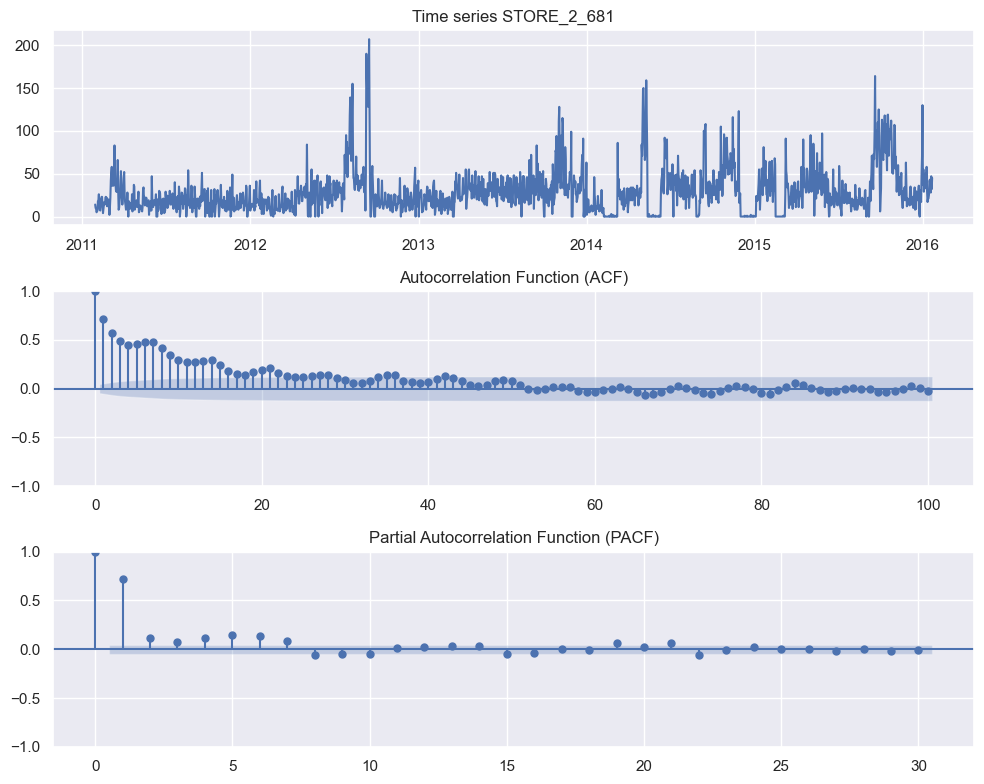

In [4]:
plot_acf_pacf(df_681, art_681, acf_lags=100, pacf_lags=30)

### 3. Обучение модели

In [5]:
# тренеровочная и тестовая выборки
data = df_681[['date', 'cnt']].set_index('date')
data_test = data[-90:]
data_train = data[:-90]

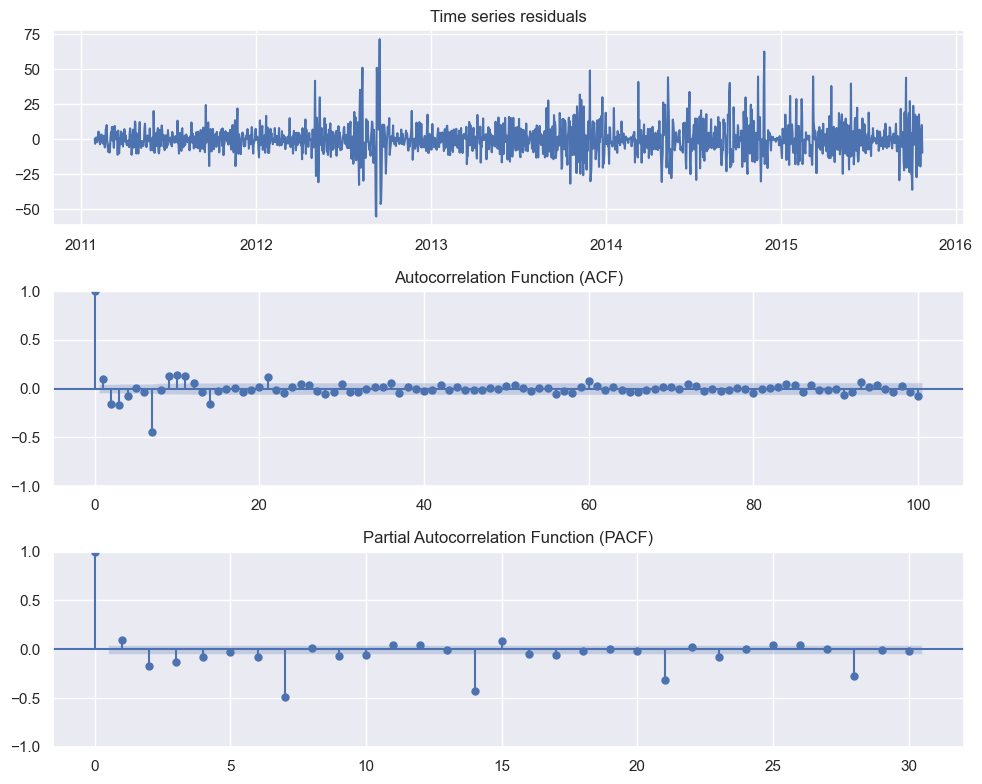

(False, 0.1, 5.872074749861962e-23)


In [6]:
# обучение модели STL

stl = STL(data_train, period=7)
result = stl.fit()

# графики остатков
plot_acf_pacf(result.resid.to_frame().reset_index(), 'residuals', acf_lags=100, pacf_lags=30)

## проверка на стационарность

print(test_trend(result.resid))

# критерии показали, что ряд остатков стационарный

#### Подбор параметров

In [7]:
print('DF:', adf_test(data_train))
print('KPSS:', kpss_test(data_train))

DF: True
KPSS: False


При одновременном применении критериев KPSS и ADF могут получиться следующие результаты: 
    
* Вариант 1: Оба теста говорят, что ряд нестационарный – значит, ряд действительно нестационарный

* Вариант 2: Оба теста говорят, что ряд стационарный – ряд стационарный

* Вариант 3: KPSS говорит, что ряд стационарный, а ADF говорит, что ряд нестационарный – значит, у вр существует детерминированный тренд, который необходимо убрать, чтобы получить стационарный вр

* Вариант 4: KPSS говорит, что ряд нестационарный, а ADF - что ряд стационарный – значит, у вр существует стохастический тренд, который необходимо убрать, чтобы получить стационарный вр


У ряда есть стохастический тренд

In [8]:
# горизонт прогнозирования
fh = ForecastingHorizon(data_test.index, is_relative=False)

# обучение модели
model = AutoARIMA(sp=7, seasonal=True, max_p=14, max_q=14, stationary=False)
model.fit(data_train)

AutoARIMA(max_p=14, max_q=14, sp=7)

In [11]:
y_pred = model.predict(fh)
model.get_fitted_params()

{'ar.L1': 0.6697155650113342,
 'ma.L1': -1.0830044016894653,
 'ma.L2': 0.1217628935692841,
 'ma.S.L7': 0.1513870428341067,
 'ma.S.L14': 0.06642229124856086,
 'sigma2': 283.67810158220243,
 'order': (1, 1, 2),
 'seasonal_order': (0, 0, 2, 7),
 'aic': 14676.421555381603,
 'aicc': 14676.470364213677,
 'bic': 14709.149875077786,
 'hqic': 14688.527723966004}

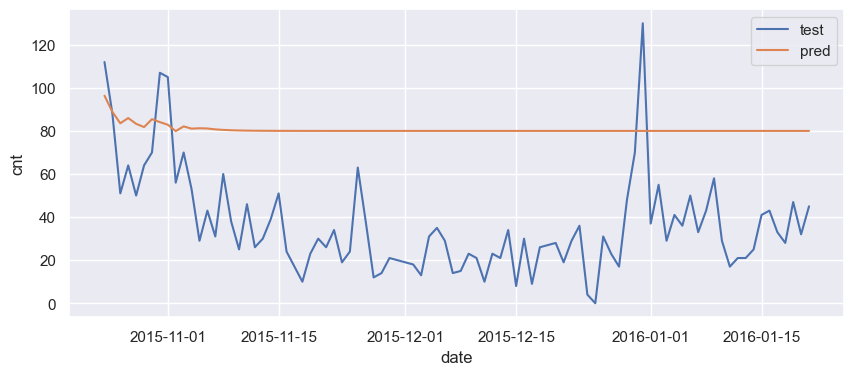

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(data_test, label='test')
ax.plot(y_pred, label='pred')
ax.set_xlabel('date')
ax.set_ylabel('cnt');
plt.legend()

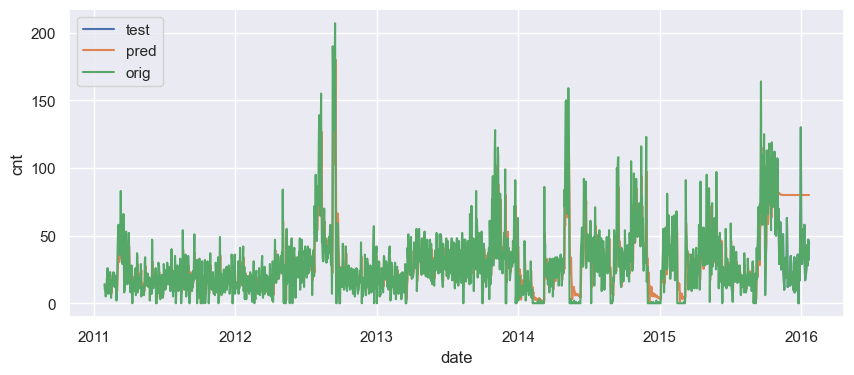

In [14]:
# горизонт прогнозирования
fh = ForecastingHorizon(data.index, is_relative=False)

y_pred = model.predict(fh)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(data_test, label='test')
ax.plot(y_pred, label='pred')
ax.plot(data, label='orig')
ax.set_xlabel('date')
ax.set_ylabel('cnt');
plt.legend()

In [15]:
# горизонт прогнозирования
fh = ForecastingHorizon(data_test.index, is_relative=False)

# обучение модели
model = AutoARIMA(sp=7, seasonal=True, max_p=14, max_q=14, stationary=True)
model.fit(data_train)

AutoARIMA(max_p=14, max_q=14, sp=7, stationary=True)

In [16]:
y_pred = model.predict(fh)
model.get_fitted_params()

{'intercept': 0.10636024371691513,
 'ar.L1': 0.8953099004646817,
 'ma.L1': -0.3327320474718581,
 'ma.L2': -0.15325285534867789,
 'ar.S.L7': 0.9969063578108927,
 'ar.S.L14': -0.04026607915555717,
 'ma.S.L7': -0.9049409063279882,
 'sigma2': 271.1975127538745,
 'order': (1, 0, 2),
 'seasonal_order': (2, 0, 1, 7),
 'aic': 14615.791557168512,
 'aicc': 14615.875278098743,
 'bic': 14659.433945053977,
 'hqic': 14631.934356940292}

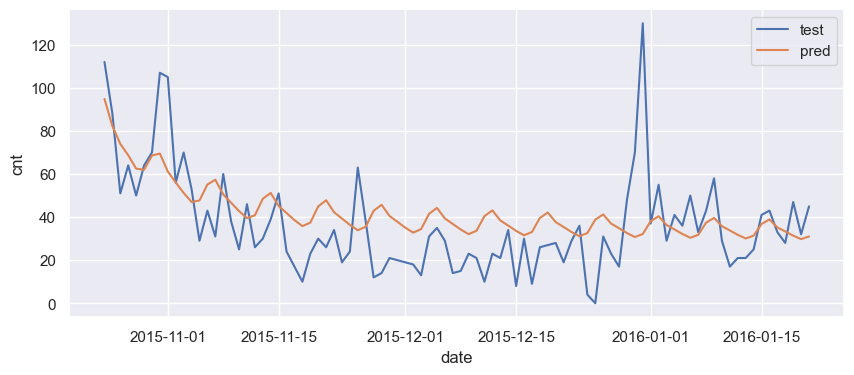

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(data_test, label='test')
ax.plot(y_pred, label='pred')
ax.set_xlabel('date')
ax.set_ylabel('cnt');
plt.legend()

In [18]:
# Оценка качества модели
mae = mean_absolute_error(data_test, y_pred)
mse = mean_squared_error(data_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')

MAE: 15.354756695317885
MSE: 402.86099217757055
